# Collaboration Network Node Classification

In [2]:
%cd /home/joel/repos/cscollab/backend

import torch
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from sklearn.decomposition import TruncatedSVD
import kuzudb.query_kuzu as query
import collections
import torch
import torch_geometric
import torch_geometric.transforms as T
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import numpy as np
import json
import functools
from sklearn.manifold import TSNE
from torch.nn import Linear
import torch.nn.functional as F
from GNN.colormap import generate_colormap


plt.style.use('default')
sns.set_style("whitegrid")

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    NUM_COLORS = len(np.unique(color))
    cmap = generate_colormap(NUM_COLORS) if NUM_COLORS > 10 else "Set3"
    fig = plt.figure(figsize=(5,5))
    plt.xticks([])
    plt.yticks([])
    # cm = plt.get_cmap('gist_rainbow')
    # ax = fig.add_subplot(111)
    # ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color,cmap=cmap)
    plt.show()
    


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Running on', device)

/home/joel/repos/cscollab/backend
[2023-03-07 10:40:08.524] [buffer_manager] [info] Initializing Buffer Pool.
[2023-03-07 10:40:08.524] [buffer_manager] [info] BufferPool Size 805306368B, #4096byte-pages 196608.0.
[2023-03-07 10:40:08.524] [buffer_manager] [info] Done Initializing Buffer Pool.
[2023-03-07 10:40:12.196] [buffer_manager] [info] Initializing Buffer Pool.
[2023-03-07 10:40:12.196] [buffer_manager] [info] BufferPool Size 268435456B, #262144byte-pages 1024.0.
[2023-03-07 10:40:12.196] [buffer_manager] [info] Done Initializing Buffer Pool.
[2023-03-07 10:40:12.196] [buffer_manager] [info] Done Initializing Buffer Manager.
[2023-03-07 10:40:12.197] [catalog] [info] Initializing catalog.
[2023-03-07 10:40:12.198] [catalog] [info] Initializing catalog done.
[2023-03-07 10:40:12.201] [storage] [info] Initializing StorageManager from directory: ./kuzudb/db
[2023-03-07 10:40:12.201] [storage] [info] Initializing NodesStatisticsAndDeletedIDs.
[2023-03-07 10:40:12.201] [storage] [inf

## Generate Dataset

First we create some mappings for the kuzudb data:
A mapping from the subarea id to the area id and a mapping of authors to their affiliated institution.
Further each reasearch area and subarea is onehot encoded and saved in a dictionary 

In [3]:

""" mapping of sub areas to areas"""
area_mapping = query.get_area_mapping()
subarea_mapping = dict(zip(area_mapping["sub-area-id"],area_mapping["area-id"]))

"""one hot encoding"""
onehot_encoder = OneHotEncoder(sparse_output=False)

area_ids = list(area_mapping["area-id"].unique())
n_area = len(area_ids)
onehot_encoded_areas = onehot_encoder.fit_transform(np.arange(n_area).reshape(n_area,1))
tensor_list_ohe_areas = list(map(lambda x: torch.tensor(x, dtype=torch.float), onehot_encoded_areas))
area_ohe_mapping = dict(zip(area_ids,tensor_list_ohe_areas))
area_binary_mapping = dict(zip(area_ids,[[0,0],[1,1],[1,0],[0,1]]))
print(area_ohe_mapping)

sub_area_ids = list(area_mapping["sub-area-id"].unique())
n_sub_area = len(sub_area_ids)
onehot_encoded_sub_areas = onehot_encoder.fit_transform(np.arange(n_sub_area).reshape(n_sub_area,1))
# tensor_list_ohe_sub_areas = list(map(lambda x: torch.tensor(x, dtype=torch.float), onehot_encoded_sub_areas))
sub_area_ohe_mapping = dict(zip(sub_area_ids,onehot_encoded_sub_areas))

"""mapping of author to institution"""
csauthors_all = query.get_csauthors_no_cache()
author_inst_map = dict(zip(csauthors_all["pid"],csauthors_all["institution"]))

{'systems': tensor([1., 0., 0., 0.]), 'ai': tensor([0., 1., 0., 0.]), 'theory': tensor([0., 0., 1., 0.]), 'interdiscip': tensor([0., 0., 0., 1.])}


Given a collaboration network we want to get for each node (author or institution) what the frequency of publications in the different areas and sub areas are and in which sub/area the most publications. For this we define a function to count the frequency and a function to get the collaboration network based on a config

In [4]:
""" count the frequency of sub/areas for a node"""
def area_frequency_counter(collab, node):
    collab_node = collab[(collab["a"]==node) | (collab["b"]==node)]
    area_counter = dict(collections.Counter(collab_node["rec_area"]))
    top_area = max(area_counter, key=area_counter.get)
    sub_area_counter = dict(collections.Counter(collab_node["rec_sub_area"]))
    top_sub_area = max(sub_area_counter, key=sub_area_counter.get)
    freq= {"area_freq":area_counter,
            "top_area":top_area,
            "sub_area_freq":sub_area_counter,
            "top_sub_area":top_sub_area}
    return freq


def get_collab_data(config):
    """get collaboration"""
    collab_flat = query.get_flat_collaboration(ignore_area=False,use_cache=False)
    collab = query.filter_collab(collab_flat,config)
    institution = config.get("institution")

    collab["rec_area"]=list(map(lambda x: subarea_mapping[x], collab["rec_sub_area"]))  
        
    node_a = "a_inst" if institution else "a_pid"
    node_b = "b_inst" if institution else "b_pid"
    collab["a"] = collab[node_a]
    collab["b"] = collab[node_b]

    """map each institution or author to an int based on the positional index"""
    nodes = list(set(collab["a"]).union(set(collab["b"])))
    node_idx = list(range(len(nodes)))
    node_idx_mapping = dict(zip(nodes, node_idx))
    node_mapping = [node_idx, nodes] #list(map(list,zip(node_idx,nodes)))

    frequency_map = dict(zip(node_idx, list(map(lambda n: area_frequency_counter(collab, n), nodes))))

    collab_weighted = query.weighted_collab(collab,institution=institution)
    collab_weighted["a"] = list(map(lambda n: node_idx_mapping[n],collab_weighted["a"]))
    collab_weighted["b"] = list(map(lambda n: node_idx_mapping[n],collab_weighted["b"]))
    
    adjacency_list = list(map(list,zip(collab_weighted["a"], collab_weighted["b"])))
    weights = collab_weighted["weight"].values

    data = {"node_mapping":node_mapping,
            "nodes": node_idx,
            "edges":adjacency_list,
            "weights":weights,
            "freq": frequency_map}
    return data

we define a config a check the collaboration network

In [119]:
"""define config as the collabortaion between institutions among Austria, Germany and Switzerland later than 2015"""
config = { "from_year": 2015,
            "region_ids":["dach"],
            "country_ids":[],
            "strict_boundary":True,
            "institution":False}

collab_data = get_collab_data(config)
print()
# Gather some statistics about the graph.
print(f'Number of first 10 nodes: {collab_data["nodes"][:10]}')
print(f'Number of first 10 edges: {collab_data["edges"][:10]}')
print(f'Number of first 10 weights: {collab_data["weights"][:10]}')
print(f'Frequency mapping of the first node: {collab_data["freq"][0]}')
print(f'Get node id of node index 0: {collab_data["node_mapping"][1][0]}')


Number of first 10 nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Number of first 10 edges: [[179, 32], [751, 173], [751, 124], [490, 207], [173, 124], [717, 700], [794, 298], [774, 264], [190, 666], [440, 689]]
Number of first 10 weights: [81 38 35 33 28 27 27 24 22 21]
Frequency mapping of the first node: {'area_freq': {'systems': 10}, 'top_area': 'systems', 'sub_area_freq': {'security': 10}, 'top_sub_area': 'security'}
Get node id of node index 0: 181/1565


Next we create the torch data object:

* y is the onehot encoding of the research area with the most publications
* x is the percentage of published subareas calculated using the ohe of the subareas

In [5]:

"""get target label as the area with the most records published"""
def get_y(nodes, freq, method=0, use_sub_areas=False):
    if use_sub_areas:
        top = list(map(lambda x: freq[x]["top_sub_area"], nodes))
        ids = sub_area_ids
        ohe = sub_area_ohe_mapping
    else:
        top = list(map(lambda x: freq[x]["top_area"], nodes))
        ids = area_ids
        ohe = area_ohe_mapping
    
    
    """get target label as torch tensor"""
    if method==0:
        """binary represnetation of y"""
        y = torch.tensor(list(map(lambda x: list(area_binary_mapping[x]),top)),dtype=torch.float)
    elif method ==1: 
        """one hot endcoding representation of y"""
        y = torch.tensor(list(map(lambda x: list(ohe[x]),top)),dtype=torch.float)
    elif method == 2:
        """int representation of y"""
        y = torch.tensor(list(map(lambda x: ids.index(x),top)),dtype=torch.long)
    return y

def sub_area_frequency(freq,n):
    sfreq = freq[n]["sub_area_freq"]
    """sum up one hot endocings of the subareas by their frequency"""
    freq_array = functools.reduce(lambda x, key: x + sfreq[key] * sub_area_ohe_mapping[key], sfreq, np.zeros(n_sub_area))
    """get frequency as percentage such that it sums up to 1"""
    freq_array_p = freq_array/sum(sfreq.values())
    return freq_array_p 

"""the percentage of published subareas"""
def get_x(nodes,freq):
    x =  torch.tensor(np.array(list(map(lambda node: sub_area_frequency(freq,node) ,nodes))), dtype=torch.float)
    return x

def gen_torch_data(nodes,edges, freq,node_mapping, use_x=True ,weights=None, y_method=0,only_features=False,use_sub_areas=False):
    
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    
    y = get_y(nodes,freq,y_method,use_sub_areas)
    
    ohe = torch.eye(len(nodes))
    if use_x:
        if only_features:
            x=get_x(nodes, freq)
        else:
            x = torch.cat((get_x(nodes, freq), ohe), dim=1)
       
    else:
        x = ohe
    
    if weights is not None:
        weights_normalized = weights / sum(weights)
        weights = torch.tensor(weights_normalized,dtype=torch.float)
        
    """create torch data object without weights"""
    data = torch_geometric.data.Data(x=x, y=y, edge_index=edge_index, num_nodes=len(nodes),edge_weight=weights,node_mapping=node_mapping)
    data = T.ToUndirected()(data) # the collaboration network is undirected
    data = T.AddSelfLoops()(data) # by adding self-loops, we ensure that aggregated messages from neighbors 
    data = T.NormalizeFeatures()(data) # features will sum up to 1
    """ define train test split"""
    transform = torch_geometric.transforms.RandomNodeSplit(split='train_rest', num_val=0.3, num_test=0)
    transform(data)
    return data

def collab_to_torch(config, weighted=False, use_x =True, y_method=0,only_features=False,use_sub_areas=False):
    collab_data = get_collab_data(config)
    nodes = collab_data["nodes"]
    edges = collab_data["edges"]
    weights = collab_data["weights"] if weighted else None
    freq = collab_data["freq"]
    node_mapping=collab_data["node_mapping"]
    data = gen_torch_data(nodes, edges, freq,node_mapping, use_x=use_x, weights=weights, y_method=y_method,only_features=only_features,use_sub_areas=use_sub_areas)
    return data

In [125]:
"""torch data object"""
data = collab_to_torch(config,only_features=True)
print(data)
print(f'Number of nodes: {data.num_nodes}')
print('Get node id of node index 0:' + data.node_mapping[1][0])
print(f'Number of edges: {data.num_edges}')
print(f'Number of features: {data.num_features}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
""" take a closer look at features"""
print(f'Features of first node: {data.x[0]}')
print(f'Sub area frequency of the first node: {collab_data["freq"][0]["sub_area_freq"]}')
print(f'Sum of ohe of the subfrquencies of the first node: {62*sub_area_ohe_mapping["hci"] + 3*sub_area_ohe_mapping["mobile+web"] + 3*sub_area_ohe_mapping["ai"]}')

Data(x=[853, 23], edge_index=[2, 3339], y=[853, 2], num_nodes=853, node_mapping=[2], train_mask=[853], val_mask=[853], test_mask=[853])
Number of nodes: 853
Get node id of node index 0:181/1565
Number of edges: 3339
Number of features: 23
Number of training nodes: 597
Has isolated nodes: False
Has self-loops: True
Is undirected: True
Features of first node: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.])
Sub area frequency of the first node: {'security': 10}
Sum of ohe of the subfrquencies of the first node: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  3.  3.  0.  0.  0.  0.  0.  0.  0.
  0. 62.  0.  0.  0.]


## Implement GNN

In [10]:
class GraphConvolution(torch_geometric.nn.MessagePassing):

    def __init__(self, in_ch, out_ch):
        super().__init__(aggr='add')

        # this linear function is used to transform node features 
        # into messages that are then "sent" to neighbors
        self.linear = torch.nn.Linear(in_ch, out_ch)
        
    def forward(self, x, edge_index):
        """
        This function uses the edges captured in edge_index, performs 
        the graph convolution function according to (Kipf, Welling 2017)
        and propagates the transformed features along the edges of the graph
        """

        # we linearly transform the features of *all* nodes stored in x
        x = self.linear(x)

        # extract source and target nodes of all edges
        source, target = edge_index
        
        # compute the (in-)degrees $d_i$ of source nodes
        deg = torch_geometric.utils.degree(target, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0

        # with this, the normalization to be applied in the propagation step can be expressed as
        # this corresponds to D^{-0.5} A * D^{-0.5} in (Kipf, Welling 2017)
        norm = deg_inv_sqrt[source] * deg_inv_sqrt[target]
        
        # the propagate function propagates messages along the edges of the graph
        # this function internally calls the functions: message(), aggregate() and update()
        # the normalization is applied in the message() function
        return self.propagate(edge_index, x=x, norm=norm)
    
    def message(self, x_j, norm):
        # x_j is a so-called **lifted** tensor which contains the source node features of each edge, 
        # i.e. it has a shape (m, out_ch) where m is the number of edges

        # a call to view(-1, 1) returns a reshaped tensor, where the second dimension 
        # is one and the first dimension is inferred automatically
        return norm.view(-1,1) * x_j



In [9]:
class GCN(torch.nn.Module):

    def __init__(self, data: torch_geometric.data.Data, out_ch, hidden_dim=16):
        super().__init__()

        # first convolution layer 
        self.input_to_hidden = GraphConvolution(data.num_node_features, hidden_dim)

        # second convolution layer
        self.hidden_to_output =  GraphConvolution(hidden_dim, out_ch)
        
    def forward(self, x, edge_index):
        
        # first graph convolution -> map nodes to representations in hidden_dim dimensions
        x = self.input_to_hidden(x, edge_index)

        # non-linear activation function
        x = torch.sigmoid(x)

        # second graph convolution -> maps node representations to output classes
        x = self.hidden_to_output(x, edge_index)

        # output class probabilities
        return torch.sigmoid(x)


In [ ]:
data = collab_to_torch(config,only_features=True) #data = collab_to_torch(config)

In [155]:
model = GCN(data, out_ch=2, hidden_dim=4)

epochs = 100
lrn_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=lrn_rate)
print(model)

GCN(
  (input_to_hidden): GraphConvolution()
  (hidden_to_output): GraphConvolution()
)


Trainging of the model


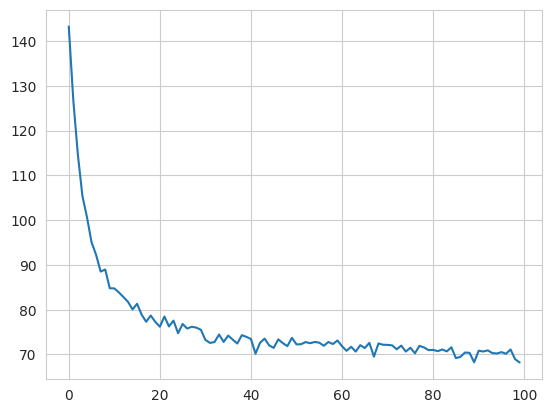

In [157]:
indices = np.arange(data.num_nodes)
losses = []
model.train()
for epoch in range(epochs):
    error = 0
    
    np.random.shuffle(indices)
    for i in indices:

        if data.train_mask[i]:

            # set gradients to zero
            optimizer.zero_grad()

            # compute loss function for training sample and backpropagate
            output = model(data.x, data.edge_index)
            loss = torch.nn.functional.binary_cross_entropy(output[i], data.y[i])
            loss.backward()

            # update parameters
            optimizer.step()

            error += loss.detach().numpy()

    losses.append(error)

# plot evolution of loss function
plt.plot(range(epochs), losses)

In [158]:
output = model.forward(data.x, data.edge_index)
# prediction = output
prediction = output.round().long()
# true_prediction = [data.y[x].argmax().item()==prediction[x].argmax().item() for x in range(data.num_nodes)]
true_prediction = np.array(prediction)==np.array(data.y)
true_prediction = np.logical_and(true_prediction[:,0],true_prediction[:,1])
accuracy=sum(true_prediction)/len(true_prediction)
print(accuracy)


0.9329710144927537


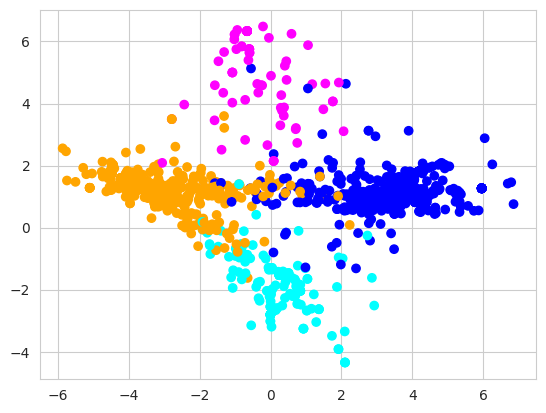

In [159]:
embedding = model.input_to_hidden.forward(data.x, data.edge_index)

svd = TruncatedSVD()
low_dim = svd.fit_transform(embedding.detach().numpy())

collab_data["freq"][0]
colors = {}
for n in range(data.num_nodes):
    top_area = collab_data["freq"][n]["top_area"] 
    idx = area_ids.index(top_area)
    if idx == 0:
        colors[n] = 'blue'
    elif idx == 1:
        colors[n] = 'orange'
    elif idx == 2:
        colors[n] = 'magenta'
    else:
        colors[n] = 'cyan'
plt.clf()
plt.scatter(low_dim[:,0], low_dim[:,1], c=colors.values())

# Try simple MLP model

In [39]:
config = { "from_year": 2015,
            "region_ids":["dach"],
            "country_ids":[],
            "strict_boundary":True,
            "institution":False}
data = collab_to_torch(config,only_features=True,y_method=2,use_sub_areas=True, weighted=True)
data.y = data.y.long()
print(data)

Data(x=[853, 23], edge_index=[2, 3339], y=[853], num_nodes=853, edge_weight=[3339], train_mask=[853], val_mask=[853], test_mask=[853])


In [171]:

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(data.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, data.y.unique().size(0))

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

MLP(
  (lin1): Linear(in_features=23, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=23, bias=True)
)
Test Accuracy: 0.9728


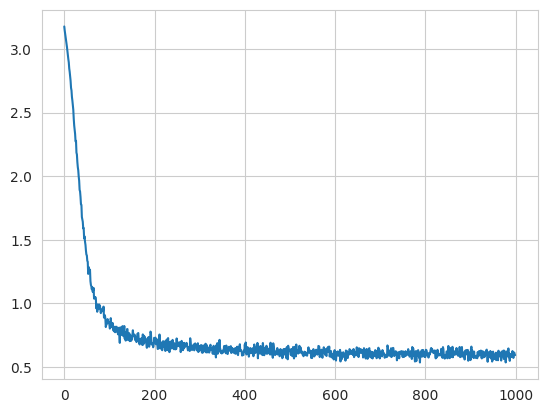

In [172]:
model = MLP(hidden_channels=16)
print(model)

criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)# Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[~data.test_mask] == data.y[~data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int((~data.test_mask).sum())  # Derive ratio of correct predictions.
      return test_acc

epochs= 1000
losses=[]
for epoch in range(epochs):
    loss = train()
    losses.append(loss.detach().numpy())

# plot evolution of loss function
plt.plot(range(epochs), losses)
    
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

In [6]:

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, data, out_channels = None):
        super().__init__()
        torch.manual_seed(1234567)
        if out_channels is None:
            out_channels = data.y.unique().size(0)
        self.conv1 = torch_geometric.nn.GCNConv(data.num_features, hidden_channels)
        self.conv2 = torch_geometric.nn.GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x


In [45]:

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads, data):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = torch_geometric.nn.GATConv(data.num_features, hidden_channels, heads=heads, edge_dim=1)  
        self.conv2 = torch_geometric.nn.GATConv(hidden_channels*heads, data.y.unique().size(0),edge_dim=1) 

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_weight
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index, edge_attr=edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index, edge_attr=edge_attr)
        return x


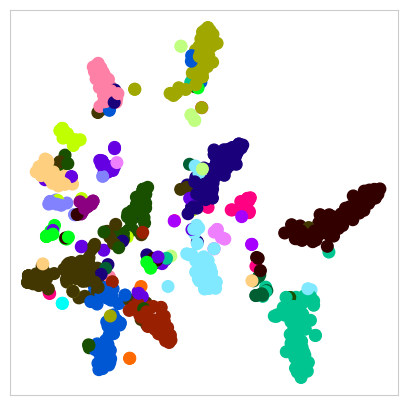

In [41]:
model1 = GCN(hidden_channels=16,data=data)
model1.eval()
out = model1(data)
visualize(out, color=data.y)

In [7]:
def train(model,data):
      model.train()
      optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
      criterion = torch.nn.CrossEntropyLoss()   
      optimizer.zero_grad()  # Clear gradients.
      out = model(data)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(model,data):
      model.eval()
      out = model(data)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[~data.test_mask] == data.y[~data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int((~data.test_mask).sum())  # Derive ratio of correct predictions.
      return test_acc

def start_training(epochs, model,data):
      epochs = epochs
      losses=[]
      for epoch in range(epochs):
            loss = train(model,data)
            losses.append(loss.detach().numpy())

      # plot evolution of loss function
      plt.plot(range(epochs), losses)
      
      test_acc = test(model,data)
      print(f'Test Accuracy: {test_acc:.4f}')

In [8]:
# get the node position from the output layer
def get_node_position(model, data):
    d = data
    out = model(data)
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
    node_idx, node_ids = data.node_mapping
    idx_node_mapping = dict(zip(node_idx,node_ids))

    node_positions = dict(zip(  list(map(lambda x: idx_node_mapping[x], range(data.num_nodes))),
                                list(map(lambda i: {"x":np.float64(z[i,0]),"y":np.float64(z[i,1])} , range(data.num_nodes)))))
    return node_positions

In [176]:
config_wd = { "from_year": 2005,
            "region_ids":["wd"],
            "country_ids":[],
            "strict_boundary":True,
            "institution":False}
data_wd = collab_to_torch(config_wd,only_features=True,y_method=2,use_sub_areas=True, weighted=True)
print(data_wd)

Data(x=[14555, 23], edge_index=[2, 137796], y=[14555], num_nodes=14555, edge_weight=[137796], node_mapping=[2], train_mask=[14555], val_mask=[14555], test_mask=[14555])


Test Accuracy: 0.9525


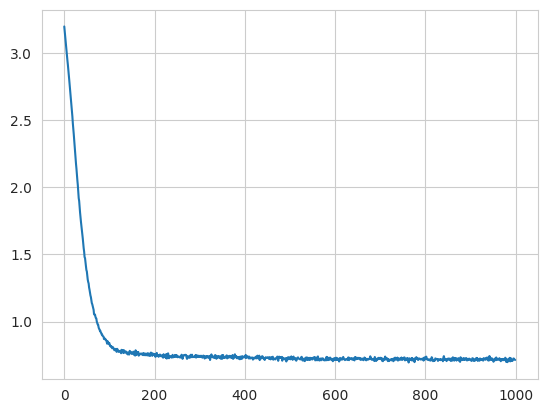

In [178]:
model_wd = GCN(hidden_channels=16,data=data_wd)
start_training(1000,model_wd,data_wd)

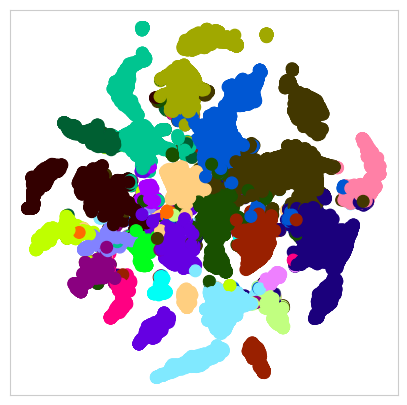

In [179]:
model_wd.eval()
out = model_wd(data_wd)
visualize(out, color=data_wd.y)

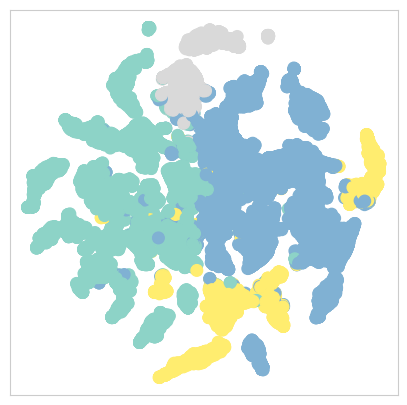

In [180]:
model_wd.eval()
"""color subareas by their area"""
area_idx = np.array(list(map(lambda x: area_ids.index(subarea_mapping[sub_area_ids[x]]), data_wd.y)))
out = model_wd(data_wd)
visualize(out, color=area_idx)

In [207]:
torch.save(model_wd.state_dict(), 'GNN/GCN_wd_subarea_weights.pth')

In [209]:
config_wd = { "from_year": 2005,
            "region_ids":["wd"],
            "country_ids":[],
            "strict_boundary":True,
            "institution":False}
data_wd_area = collab_to_torch(config_wd,only_features=True,y_method=2,use_sub_areas=False, weighted=True)
print(data_wd_area)

Data(x=[14555, 23], edge_index=[2, 137796], y=[14555], num_nodes=14555, edge_weight=[137796], node_mapping=[2], train_mask=[14555], val_mask=[14555], test_mask=[14555])


Test Accuracy: 0.9874


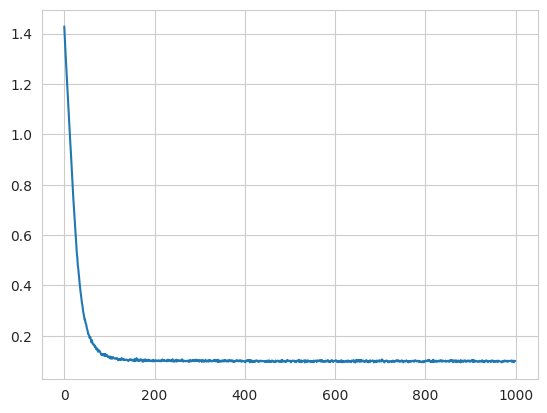

In [214]:
model_wd_area = GCN(hidden_channels=16,data=data_wd_area)
start_training(1000,model_wd_area,data_wd_area)

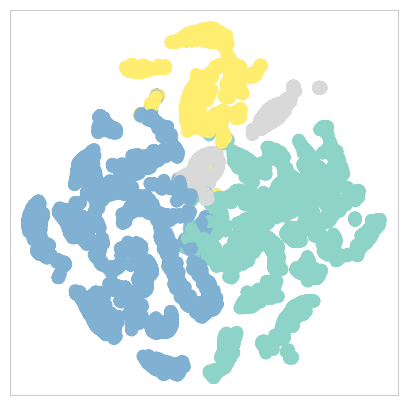

In [215]:
model_wd_area.eval()
out = model_wd_area(data_wd_area)
visualize(out, color=data_wd_area.y)

In [216]:
torch.save(model_wd_area.state_dict(), 'GNN/GCN_wd_area_weights.pth')

In [218]:
config_wd_inst = { "from_year": 2005,
            "region_ids":["wd"],
            "country_ids":[],
            "strict_boundary":True,
            "institution":True}
data_wd_inst = collab_to_torch(config_wd_inst,only_features=True,y_method=2,use_sub_areas=True, weighted=True)
print(data_wd_inst)

Data(x=[597, 23], edge_index=[2, 40787], y=[597], num_nodes=597, edge_weight=[40787], node_mapping=[2], train_mask=[597], val_mask=[597], test_mask=[597])


Test Accuracy: 0.8811


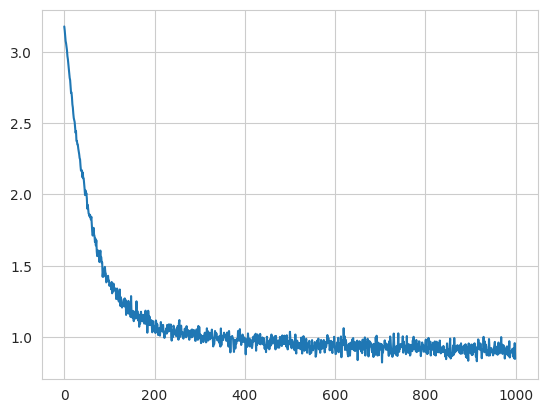

In [225]:
model_wd_inst = GCN(hidden_channels=16,data=data_wd_inst,out_channels=23)
start_training(1000,model_wd_inst,data_wd_inst)

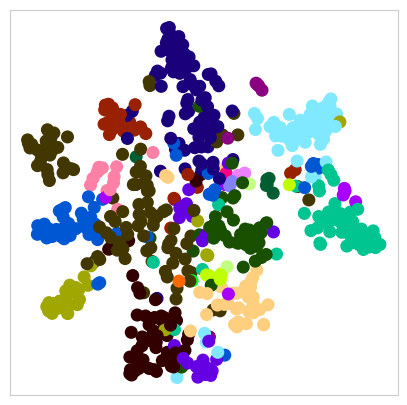

In [226]:
model_wd_inst.eval()
out = model_wd_inst(data_wd_inst)
visualize(out, color=data_wd_inst.y)

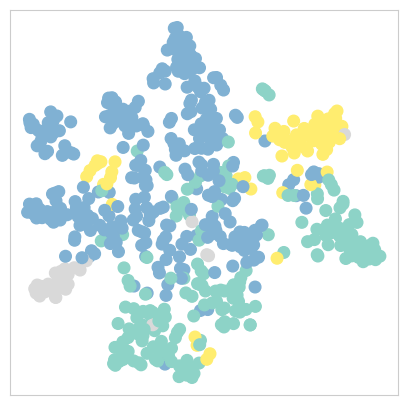

In [227]:
model_wd_inst.eval()
"""color subareas by their area"""
area_idx = np.array(list(map(lambda x: area_ids.index(subarea_mapping[sub_area_ids[x]]), data_wd_inst.y)))
out = model_wd_inst(data_wd_inst)
visualize(out, color=area_idx)

In [228]:
torch.save(model_wd_inst.state_dict(), 'GNN/GCN_wd_inst_weights.pth')

In [229]:
config_wd_inst_area = { "from_year": 2005,
            "region_ids":["wd"],
            "country_ids":[],
            "strict_boundary":True,
            "institution":True}
data_wd_inst_area = collab_to_torch(config_wd_inst_area,only_features=True,y_method=2,use_sub_areas=False, weighted=True)
print(data_wd_inst_area)

Data(x=[597, 23], edge_index=[2, 40787], y=[597], num_nodes=597, edge_weight=[40787], node_mapping=[2], train_mask=[597], val_mask=[597], test_mask=[597])


Test Accuracy: 0.9816


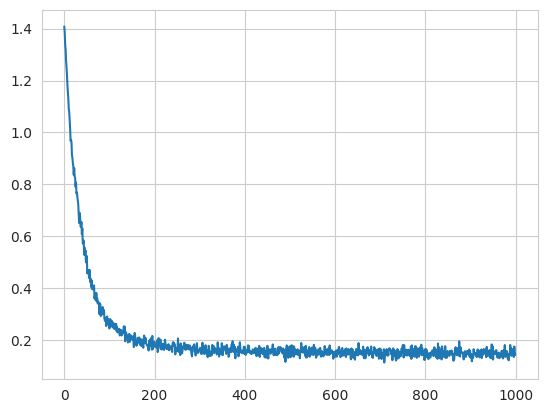

In [232]:
model_wd_inst_area = GCN(hidden_channels=16,data=data_wd_inst_area)
start_training(1000,model_wd_inst_area,data_wd_inst_area)

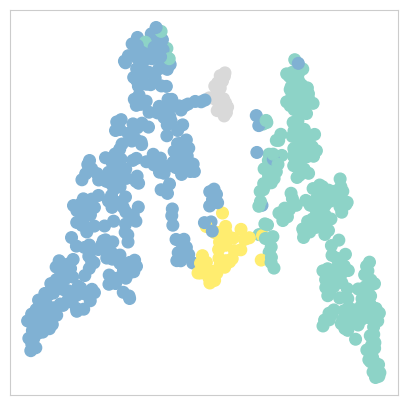

In [233]:
model_wd_inst_area.eval()
out = model_wd_inst_area(data_wd_inst_area)
visualize(out, color=data_wd_inst_area.y)

In [ ]:
torch.save(model_wd_inst_area.state_dict(), 'GNN/GCN_wd_inst_area_weights.pth')

In [193]:
node_position = get_node_position(model_wd,data_wd)

In [194]:
with open("GNN/position_wd_sub_area.json", "w") as f:
    json.dump(node_position,f,indent=4)

In [9]:
config_dach = { "from_year": 2015,
            "region_ids":["dach"],
            "country_ids":[],
            "strict_boundary":True,
            "institution":False}
data_dach = collab_to_torch(config_dach,only_features=True,y_method=2,use_sub_areas=True, weighted=True)
print(data_dach)

Data(x=[853, 23], edge_index=[2, 3339], y=[853], num_nodes=853, edge_weight=[3339], node_mapping=[2], train_mask=[853], val_mask=[853], test_mask=[853])


In [204]:
test(model_wd,data_dach)

0.9507620164126612

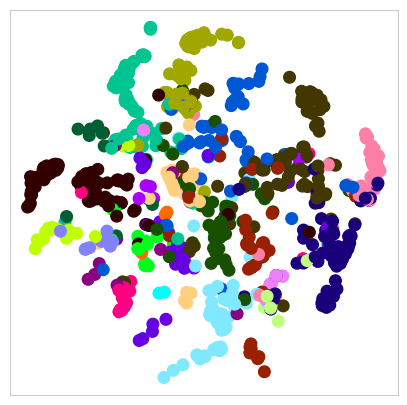

In [202]:
# get precalculated positions from model wd sub_area
data = data_dach
with open("GNN/position_wd_sub_area.json") as f:
    node_position = json.load(f)
node_idx, node_ids = data.node_mapping
idx_node_mapping = dict(zip(node_idx,node_ids))
x = list(map(lambda x: node_position[x]["x"], node_ids))
y = list(map(lambda x: node_position[x]["y"], node_ids))
area_idx = np.array(list(map(lambda x: area_ids.index(subarea_mapping[sub_area_ids[x]]), data.y)))
color = data.y

NUM_COLORS = len(np.unique(color))
cmap = generate_colormap(NUM_COLORS) if NUM_COLORS > 10 else "Set3"
fig = plt.figure(figsize=(5,5))
plt.xticks([])
plt.yticks([])
plt.scatter(x, y, s=70, c=color,cmap=cmap)
plt.show()



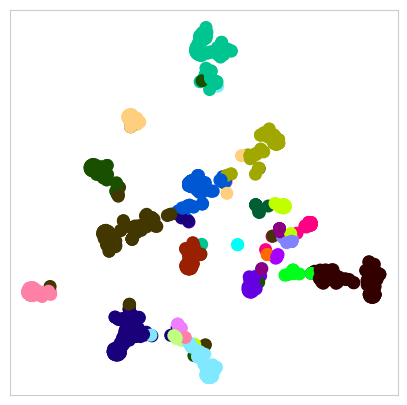

In [203]:
model_wd.eval()
"""color subareas by their area"""
area_idx = np.array(list(map(lambda x: area_ids.index(subarea_mapping[sub_area_ids[x]]), data_dach.y)))
out = model_wd(data_dach)
visualize(out, color=data_dach.y)

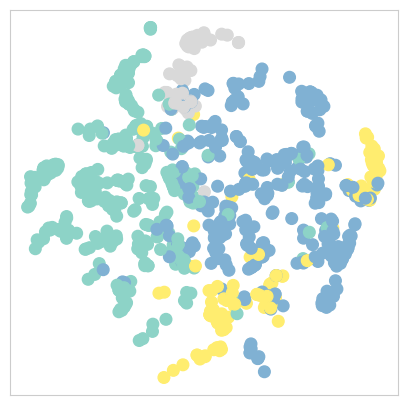

In [205]:
data = data_dach
with open("GNN/position_wd_sub_area.json") as f:
    node_position = json.load(f)
node_idx, node_ids = data.node_mapping
idx_node_mapping = dict(zip(node_idx,node_ids))
x = list(map(lambda x: node_position[x]["x"], node_ids))
y = list(map(lambda x: node_position[x]["y"], node_ids))
area_idx = np.array(list(map(lambda x: area_ids.index(subarea_mapping[sub_area_ids[x]]), data.y)))
color = area_idx

NUM_COLORS = len(np.unique(color))
cmap = generate_colormap(NUM_COLORS) if NUM_COLORS > 10 else "Set3"
fig = plt.figure(figsize=(5,5))
plt.xticks([])
plt.yticks([])
plt.scatter(x, y, s=70, c=color,cmap=cmap)
plt.show()

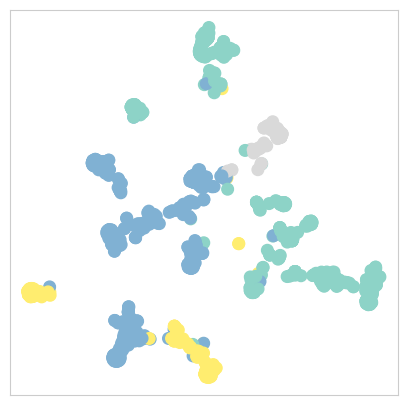

In [206]:
model_wd.eval()
"""color subareas by their area"""
area_idx = np.array(list(map(lambda x: area_ids.index(subarea_mapping[sub_area_ids[x]]), data_dach.y)))
out = model_wd(data_dach)
visualize(out, color=area_idx)

In [126]:
config_dach = { "from_year": 2005,
            "region_ids":["dach"],
            "country_ids":[],
            "strict_boundary":True,
            "institution":False}
data_dach_area = collab_to_torch(config_dach,only_features=True,y_method=2,use_sub_areas=False, weighted=True)
print(data_dach_area)

Data(x=[1104, 23], edge_index=[2, 5252], y=[1104], num_nodes=1104, edge_weight=[5252], node_mapping=[2], train_mask=[1104], val_mask=[1104], test_mask=[1104])


Test Accuracy: 0.9918


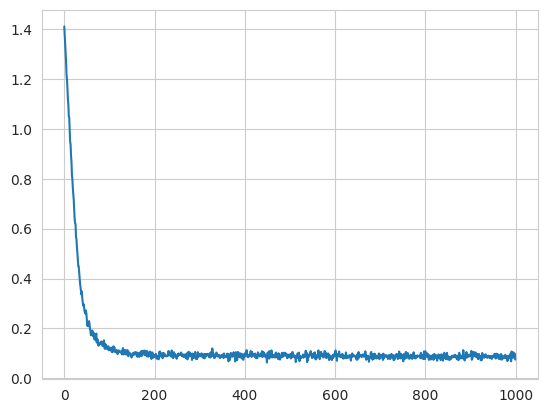

In [127]:
model = GCN(hidden_channels=16,data=data_dach_area)
start_training(1000,model,data_dach_area)

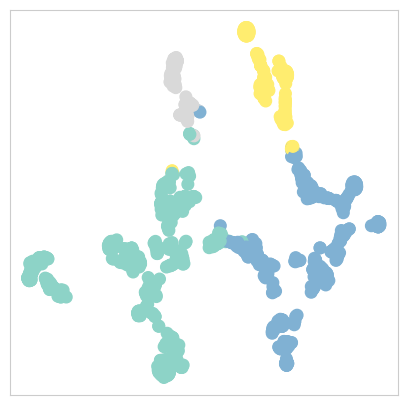

In [128]:
model.eval()
out = model(data_dach_area)
visualize(out, color=data_dach_area.y)

In [71]:
torch.save(model.state_dict(), 'GNN/GCN_wd_model_weights.pth')

In [66]:
model = GCN(hidden_channels=16,data=data)
test(model,data)
model.load_state_dict(torch.load("GNN/GCN_dach_model_weights.pth"))
test(model,data)

0.9664855072463768

In [74]:
model = GCN(hidden_channels=16,data=data_dach)
test(model,data_dach)
model.load_state_dict(torch.load("GNN/GCN_wd_model_weights.pth"))
test(model,data_dach)

0.9460726846424384

Test Accuracy: 0.8379


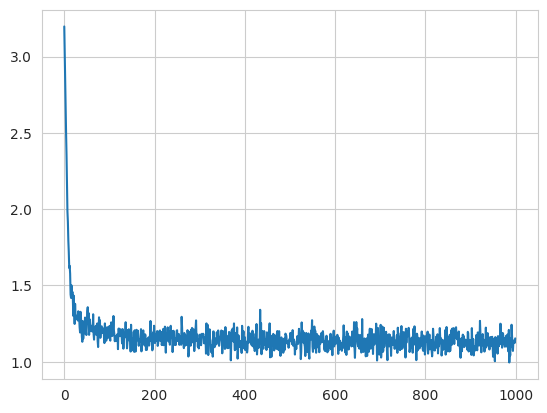

In [270]:
model = GAT(hidden_channels=16,heads=8,data=data)
start_training(1000,model,data)

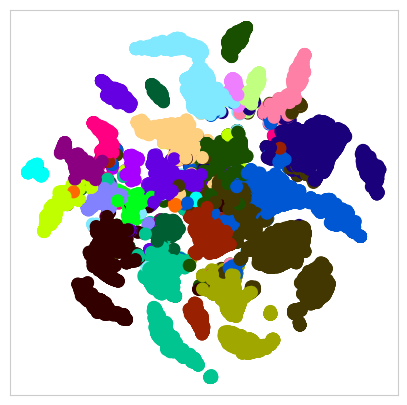

In [69]:
model.eval()
out = model(data)
visualize(out, color=data.y)

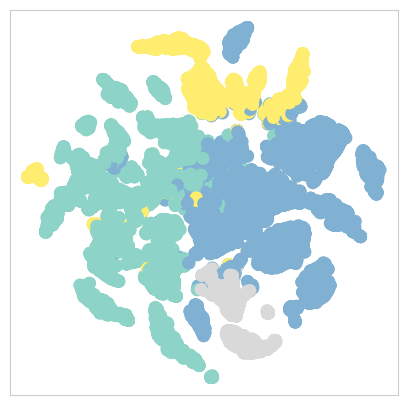

In [70]:
model.eval()
"""color subareas by their area"""
area_idx = np.array(list(map(lambda x: area_ids.index(subarea_mapping[sub_area_ids[x]]), data.y)))
out = model(data)
visualize(out, color=area_idx)

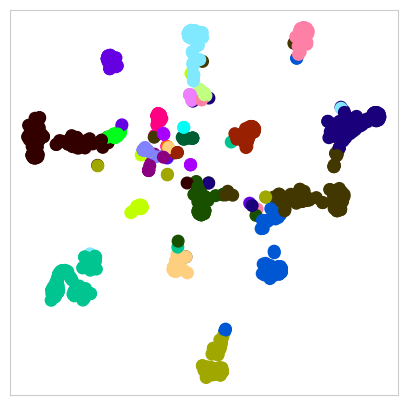

In [75]:
model.eval()
out = model(data_dach)
visualize(out, color=data_dach.y)

model.eval()
out = model(data_dach_area)
visualize(out, color=data_dach_area.y)

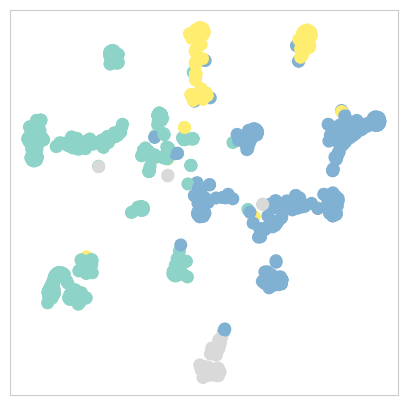

In [76]:
model.eval()
"""color subareas by their area"""
area_idx = np.array(list(map(lambda x: area_ids.index(subarea_mapping[sub_area_ids[x]]), data_dach.y)))
out = model(data_dach)
visualize(out, color=area_idx)

In [138]:
out = model(data_dach_area)
node_idx, node_ids = data_dach_area.node_mapping
idx_node_mapping = dict(zip(node_idx,node_ids))
z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
node_positions = dict(zip(  list(map(lambda x: idx_node_mapping[x], range(data_dach_area.num_nodes))),
                            list(map(lambda i: {"x":z[i,0],"y":z[i,1]} , range(data_dach_area.num_nodes)))))
node_positions

{'181/1565': {'x': -54.433853, 'y': -9.408188},
 'f/WolfgangFaber': {'x': 12.768666, 'y': -7.3634634},
 'a/GustavoAlonso': {'x': -2.5916417, 'y': -2.4912877},
 '46/2289': {'x': 8.827847, 'y': 35.350685},
 '145/5081': {'x': -12.227305, 'y': 3.2877076},
 '32/2607': {'x': -13.632082, 'y': 29.814856},
 '42/998': {'x': 28.169867, 'y': -8.208075},
 '36/3665': {'x': -50.182915, 'y': -7.9493003},
 '93/5872': {'x': 18.438742, 'y': -18.018278},
 '35/9056': {'x': -49.433544, 'y': -11.878712},
 '10/2223': {'x': -12.166185, 'y': 30.260614},
 '89/9395': {'x': -13.000219, 'y': 9.975999},
 's/TobiasScheffer': {'x': 33.717873, 'y': -5.200247},
 '60/4140': {'x': 35.245083, 'y': -5.6976657},
 '26/6488': {'x': -14.442548, 'y': -0.059686646},
 '31/5444': {'x': -24.089943, 'y': -14.438772},
 '179/8624': {'x': -20.89891, 'y': -10.15805},
 '131/7133': {'x': 36.772057, 'y': -2.1938374},
 'p/CesarePautasso': {'x': -25.109482, 'y': -4.3443074},
 'e/ThomasErtl': {'x': 14.849274, 'y': 23.983534},
 '24/2656': {'x':

In [140]:
config_inst = { "from_year": 2005,
            "region_ids":["wd"],
            "country_ids":[],
            "strict_boundary":True,
            "institution":True}
data_inst_area = collab_to_torch(config_inst,only_features=True,y_method=2,use_sub_areas=False, weighted=True)
print(data_inst_area)

Data(x=[597, 23], edge_index=[2, 40787], y=[597], num_nodes=597, edge_weight=[40787], node_mapping=[2], train_mask=[597], val_mask=[597], test_mask=[597])


Test Accuracy: 0.9799


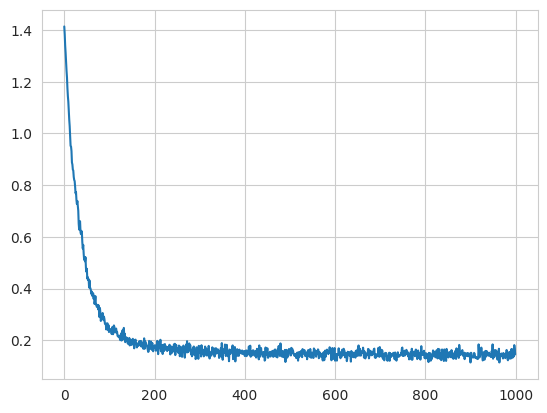

In [141]:
model_inst_area = GCN(hidden_channels=16,data=data_inst_area)
start_training(1000,model_inst_area,data_inst_area)

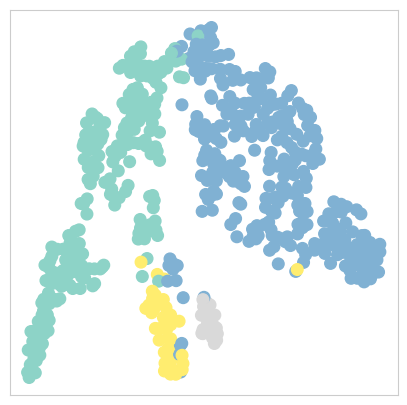

In [145]:
model_inst_area.eval()
out = model_inst_area(data_inst_area)
visualize(out, color=data_inst_area.y)

In [158]:
torch.save(model_inst_area.state_dict(), 'GNN/GCN_wd_inst_area_weights.pth')

In [159]:
config_inst = { "from_year": 2005,
            "region_ids":["wd"],
            "country_ids":[],
            "strict_boundary":True,
            "institution":True}
data_inst_subarea = collab_to_torch(config_inst,only_features=True,y_method=2,use_sub_areas=True, weighted=True)
print(data_inst_subarea)

Data(x=[597, 23], edge_index=[2, 40787], y=[597], num_nodes=597, edge_weight=[40787], node_mapping=[2], train_mask=[597], val_mask=[597], test_mask=[597])


Test Accuracy: 0.8794


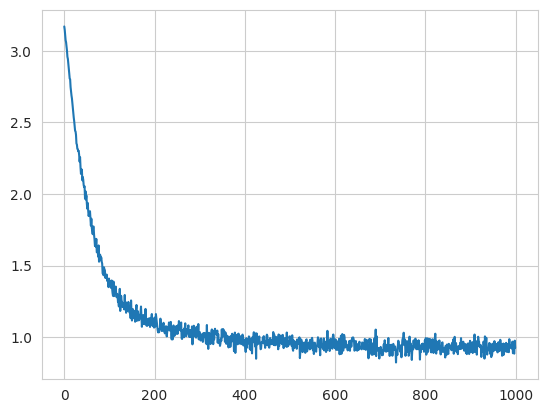

In [168]:
model_inst_subarea = GCN(hidden_channels=16,data=data_inst_subarea,out_channels=23)
start_training(1000,model_inst_subarea,data_inst_subarea)

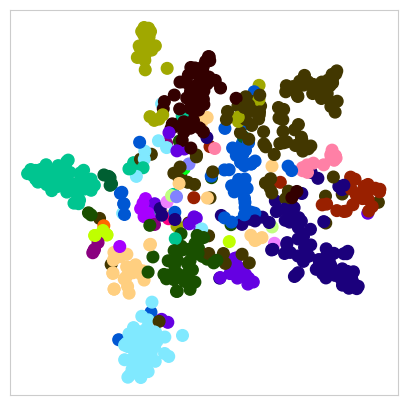

In [169]:
model_inst_subarea.eval()
out = model_inst_subarea(data_inst_subarea)
visualize(out, color=data_inst_subarea.y)

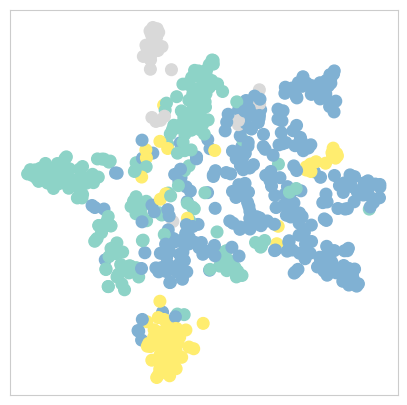

In [170]:
model_inst_subarea.eval()
"""color subareas by their area"""
area_idx = np.array(list(map(lambda x: area_ids.index(subarea_mapping[sub_area_ids[x]]), data_inst_subarea.y)))
out = model_inst_subarea(data_inst_subarea)
visualize(out, color=area_idx)

In [143]:
config_dach_inst = { "from_year": 2005,
            "region_ids":["dach"],
            "country_ids":[],
            "strict_boundary":True,
            "institution":True}
data_dach_inst_area = collab_to_torch(config_dach_inst,only_features=True,y_method=2,use_sub_areas=False, weighted=True)
print(data_dach_inst_area)

Data(x=[81, 23], edge_index=[2, 1743], y=[81], num_nodes=81, edge_weight=[1743], node_mapping=[2], train_mask=[81], val_mask=[81], test_mask=[81])


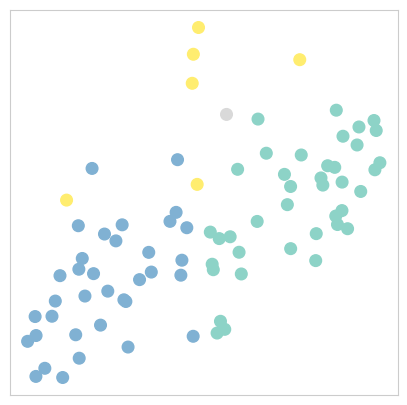

In [148]:
out = model_inst_area(data_dach_inst_area)
visualize(out, color=data_dach_inst_area.y)

In [151]:
d = data_inst_area
out = model_inst_area(d)
node_idx, node_ids = d.node_mapping
idx_node_mapping = dict(zip(node_idx,node_ids))

node_positions = dict(zip(  list(map(lambda x: idx_node_mapping[x], range(d.num_nodes))),
                            list(map(lambda i: out[i] , range(d.num_nodes)))))
node_positions["TU Munich"]

tensor([ 0.1127,  2.4581, -2.0745, -1.5829], grad_fn=<SelectBackward0>)

In [152]:
d = data_dach_inst_area
out = model_inst_area(d)
node_idx, node_ids = d.node_mapping
idx_node_mapping = dict(zip(node_idx,node_ids))

node_positions = dict(zip(  list(map(lambda x: idx_node_mapping[x], range(d.num_nodes))),
                            list(map(lambda i: out[i] , range(d.num_nodes)))))
node_positions["TU Munich"]

tensor([-0.2913,  2.7667, -2.4152, -1.1962], grad_fn=<SelectBackward0>)

In [12]:
model = GCN(hidden_channels=16,data=data_dach)
test(model,data_dach)
model.load_state_dict(torch.load("GNN/GCN_wd_subarea_weights.pth"))
test(model,data_dach)

0.9507620164126612

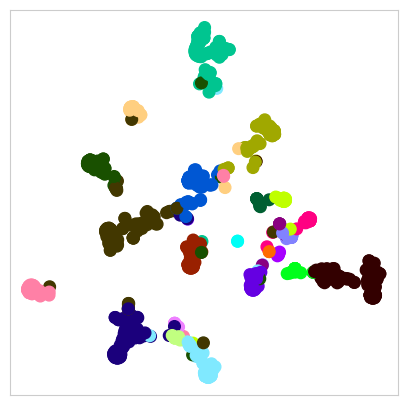

In [11]:
model.eval()
out = model(data_dach)
visualize(out, color=data_dach.y)